In [40]:
import pandas as pd
from textblob import TextBlob
import numpy as np
import os
from matplotlib import pyplot as plt

pjoin = os.path.join


In [49]:
tweet_csv_dir = './data/tweet/brexit'

tweet_csv_file = pjoin(tweet_csv_dir, 'brexit_2016-06-01_2016-07-15_toptweets_10000.csv')

df = pd.read_csv(tweet_csv_file, parse_dates=[1], error_bad_lines=False, delimiter=';')

# Add separate date and time columns
df.rename(columns={'date' : 'DateTime'}, inplace=True)

df['Date'] = df['DateTime'].dt.date

# Set date as the index for df
df.set_index('Date', inplace=True)

# Cleanup
df.drop(columns=['geo', 'permalink', 'DateTime', 'username', 'mentions', 'hashtags', 'id'], inplace=True)

df.head()


b'Skipping line 408: expected 10 fields, saw 11\nSkipping line 536: expected 10 fields, saw 11\nSkipping line 1066: expected 10 fields, saw 12\nSkipping line 2172: expected 10 fields, saw 11\nSkipping line 2636: expected 10 fields, saw 11\nSkipping line 2809: expected 10 fields, saw 11\nSkipping line 4051: expected 10 fields, saw 11\nSkipping line 7702: expected 10 fields, saw 11\nSkipping line 7729: expected 10 fields, saw 11\nSkipping line 8348: expected 10 fields, saw 11\nSkipping line 9054: expected 10 fields, saw 11\n'


,retweets,favorites,text
Date,,,
2016-07-15,30,38,How Sky News is making this attack about Brexi...
2016-07-15,4,7,Where is the voice sayingthis whole brexit is ...
2016-07-15,52,53,Don't let truth & reason die THERE IS NO MANDA...
2016-07-15,8,7,Brilliant article on why #Brexit is a disaster...
2016-07-15,0,1,"Die einen wollen #Deutschland abschaffen, die ..."


## Two Sentiment Classifiers: NLTK vs TextBlob

Here, we compare results of two sentiment classifiers, one from NLTK library and the other one from TextBlob.

In [50]:
# First, classify with pattern based TextBlob classifier
# Score is labeled as: TextBlob score
get_score_with_pb_clf = lambda text: TextBlob(text).sentiment.polarity
df['TextBlob Score'] = df['text'].apply(get_score_with_pb_clf)

# Next, classify with NLTK's sentiment classifier
# Score is labeled as: NLTK score
import nltk
# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
s = SentimentIntensityAnalyzer()
get_nltk_score = lambda text: s.polarity_scores(text)['compound']
df['NLTK Score'] = df['text'].apply(get_nltk_score)

df.head()

,retweets,favorites,text,TextBlob Score,NLTK Score
Date,,,,,
2016-07-15,30,38,How Sky News is making this attack about Brexi...,-0.05,-0.8135
2016-07-15,4,7,Where is the voice sayingthis whole brexit is ...,0.30,-0.2960
2016-07-15,52,53,Don't let truth & reason die THERE IS NO MANDA...,0.00,-0.8314
2016-07-15,8,7,Brilliant article on why #Brexit is a disaster...,0.90,-0.3612
2016-07-15,0,1,"Die einen wollen #Deutschland abschaffen, die ...",0.00,-0.8316


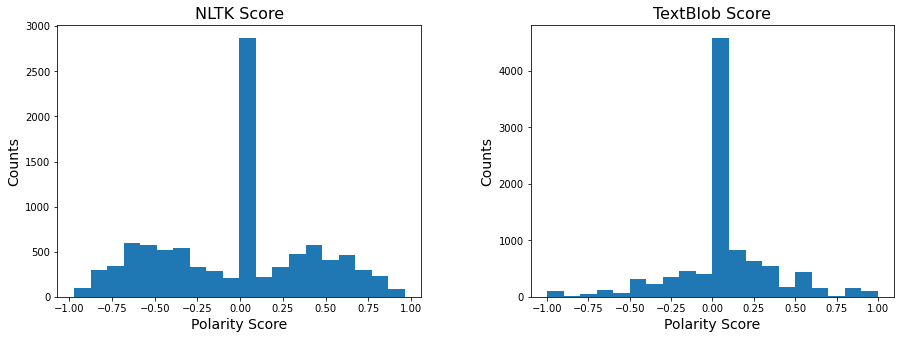

In [51]:
axes = df[['NLTK Score', 'TextBlob Score']].hist(figsize=(15,5), grid=False, bins=20)
axes = axes[0]
for ax in axes:
    ax.set_xlabel('Polarity Score', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)

axes[0].set_title('NLTK Score', fontsize=16)
axes[1].set_title('TextBlob Score', fontsize=16)

fig_dir = './fig/tweet/sentiment/diff_classifiers'

plt.savefig(pjoin(fig_dir, 'nltk_vs_textblob_all_scores.pdf'))

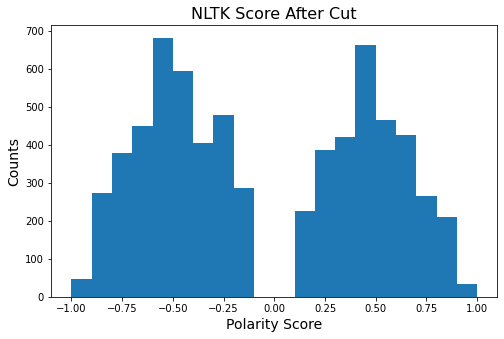

In [88]:
# Remove entries with |NLTK Score| < 0.1
cleandf = df[np.abs(df['NLTK Score']) >= 0.1]
ax = cleandf['NLTK Score'].hist(bins=np.linspace(-1,1,21), figsize=(8,5), grid=False)
ax.set_xlabel('Polarity Score', fontsize=14)
ax.set_ylabel('Counts', fontsize=14)
ax.set_title('NLTK Score After Cut', fontsize=16)

plt.savefig(pjoin(fig_dir, 'nltk_scores_after_01_cut.pdf'))


In [89]:
def get_sentiment(score):
    if score >= 0.1:
        return 'P'
    return 'N'

df['NLTK Sentiment'] = df['NLTK Score'].apply(get_sentiment)
df.head()

,retweets,favorites,text,TextBlob Score,NLTK Score,NLTK Sentiment
Date,,,,,,
2016-07-15,30,38,How Sky News is making this attack about Brexi...,-0.05,-0.8135,N
2016-07-15,4,7,Where is the voice sayingthis whole brexit is ...,0.30,-0.2960,N
2016-07-15,52,53,Don't let truth & reason die THERE IS NO MANDA...,0.00,-0.8314,N
2016-07-15,8,7,Brilliant article on why #Brexit is a disaster...,0.90,-0.3612,N
2016-07-15,0,1,"Die einen wollen #Deutschland abschaffen, die ...",0.00,-0.8316,N


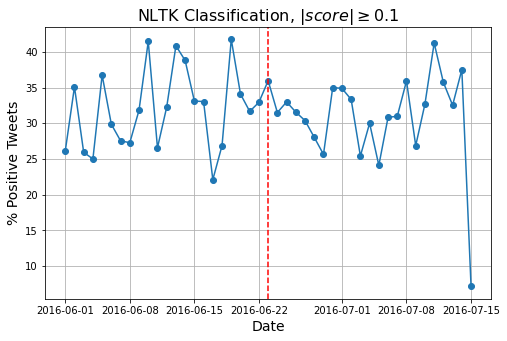

In [90]:
grouped = df.groupby('Date')
num_tweets = grouped['NLTK Score'].count()

pos_and_neg = grouped['NLTK Sentiment'].value_counts().unstack()
pos_and_neg['% P'] = pos_and_neg['P'] * 100 / num_tweets
ax = pos_and_neg['% P'].plot(figsize=(8,5), grid=True, marker='o')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('% Positive Tweets', fontsize=14)
ax.set_title(r'NLTK Classification, $|score| \geq 0.1$', fontsize=16)

ylim = ax.get_ylim()
ax.plot([pd.to_datetime('2016-06-23')]*2, ylim, 'r--')
ax.set_ylim(ylim)

plt.savefig(pjoin(fig_dir, 'nltk_clf_with_01_threshold.pdf'))